In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib



Bad key "text.kerning_factor" on line 4 in
/Users/csababoth/anaconda3/envs/tf1/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import networkx as nx

In [3]:
import tensorflow as tf
sess = tf.compat.v1.InteractiveSession()

In [4]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

In [5]:
from scipy import spatial
from scipy.spatial import cKDTree
import scipy.sparse as sp

In [6]:
from numpy import linalg as LA
from numpy.linalg import inv
from sklearn.decomposition import PCA
import pandas as pd

import cmath

In [7]:
import time
class tictoc():
    def __init__(self):
        self.prev = 0
        self.now = 0
    def tic(self):
        self.prev = time.time()
    def toc(self):
        self.now = time.time()
        print( "dt(s) = %.3g" %(self.now - self.prev))
        t = self.now - self.prev
        self.prev = time.time()
        return t
        
tt = tictoc()

In [189]:
#Circular network
i = 500
Adj = eye(i,i,1)+eye(i,i,-1) 
Adj[0][-1] = 1
Adj[-1][0] = 1



In [190]:
#generate a graph from the adjacency matrix
G = nx.from_numpy_matrix(Adj)

In [156]:
G = nx.grid_2d_graph(250, 250, periodic = True)


#relable the graph and use one integers as an id
label = ([ i[0] for i in list(G.nodes(data=True))])

mapping = dict([ [label[i], i] for i in range(len(label))])
G = nx.relabel_nodes(G, mapping)


In [193]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [194]:
#adjacency mtx


A = nx.to_numpy_matrix(G)
#A = matrix(A)


N = len(A)

print(N)

500


In [195]:
len(A)

500

In [196]:
#first neighbors
#adjacency_list = torch.where(torch.triu(torch.tensor(A)))
adjacency_list = torch.where((torch.tensor(A)))
len(adjacency_list[0])

1000

In [200]:
#second neighbors
sa = []

for i in G.nodes(data= True):
    for j in G.neighbors(i[0]):
        for k in G.neighbors(j):
            if i[0] != j and k != j: #i[0] !=k
                sa += [[i[0], j, k]]
                
sa = array(sa)

len(sa)

2000

In [201]:
#first neighbor impact to other first neighbor
fa = []

for i in G.nodes(data= True):
    for j in G.neighbors(i[0]):
        for k in G.neighbors(i[0]):
            if j != i[0] and k!= i[0]: #j != k:
                fa += [[i[0], j, k]]
                
fa = array(fa)

len(fa)

2000

In [202]:
fadj = ( torch.tensor(fa[:,0]), torch.tensor(fa[:,1]), torch.tensor(fa[:,2]))

In [203]:
sadj = ( torch.tensor(sa[:,0]), torch.tensor(sa[:,1]), torch.tensor(sa[:,2]))

In [204]:
#sparse
A = sp.coo_matrix(A)

A_norm = A + sp.eye(N)
D_norm = sp.diags((1/np.sqrt(A_norm.sum(0))).tolist()[0])
D_norm = D_norm.tocsr()
DAD = D_norm.dot(A_norm.dot(D_norm))
DAD = DAD.tocoo()

DAD = sparse_mx_to_torch_sparse_tensor(DAD)

In [207]:
#input, output dimensions
dim = 1
#x = torch.eye(N) #.to(device)
x = sp.eye(N)
x = x.tocoo()
x = sparse_mx_to_torch_sparse_tensor(x)

In [208]:
class GCN(nn.Module):
    def __init__(self, input_dim, output_dim, adj_mx):
        super(GCN, self).__init__()
        self.input_dim = input_dim
        self.adj_mx = adj_mx
        self.output_dim = output_dim
        #self.dense = nn.Linear(input_dim, output_dim,bias=False)
        self.weight = torch.nn.Parameter(torch.nn.init.uniform_(torch.FloatTensor(self.input_dim, self.output_dim), a=0.0, b=2*pi )) 
    #def reset_parameters(self):
    #    stdv = 1. / math.sqrt(self.weight.size(1))
    #    self.weight.data.uniform_(-stdv, stdv)
        
    def forward(self, input):
        support = torch.spmm(input, self.weight)
        output = torch.spmm(self.adj_mx, support)
        
        return output

In [209]:
class NeuralSync_Sparse(nn.Module):
    def __init__(self, num_nodes, output_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3,adj_mtx):
        super(NeuralSync_Sparse, self).__init__()
        self.num_nodes = num_nodes
        self.output_dim = output_dim
        self.hidden_dim_1 = hidden_dim_1
        self.hidden_dim_2 = hidden_dim_2
        self.hidden_dim_3 = hidden_dim_3
        self.adj_mtx = adj_mtx
        
        self.weight1 = torch.nn.Parameter(torch.nn.init.uniform_(torch.FloatTensor(self.num_nodes, self.hidden_dim_1), a=0.0, b=2*pi ))
        
        self.GCN1 = GCN(self.hidden_dim_1, self.output_dim,self.adj_mtx.float())
        
        self.LR = nn.LeakyReLU()
        self.Sigmoid = nn.Sigmoid()
        
 
    def forward(self, inp):
        x = torch.spmm(inp, self.weight1)
        
        gnn1 = self.GCN1(x)
        
        gnn1 %= (2*pi)
  
        output = self.LR(gnn1)
    
        #output = self.Sigmoid(gnn1)*(2*pi)
    
        return  output

In [210]:
class LinearSync_Sparse(nn.Module):
    def __init__(self, num_nodes, output_dim):
        super(LinearSync_Sparse, self).__init__()
        self.num_nodes = num_nodes
        self.output_dim = output_dim
        
        #self.weight1 = torch.nn.Parameter(torch.nn.init.uniform_(torch.FloatTensor(self.num_nodes, self.output_dim), a=0.0, b=2*pi ))
        self.weight1 = torch.nn.Parameter(torch.nn.init.uniform_(torch.FloatTensor(self.num_nodes, self.output_dim), a=0.0, b=2*pi ))
        
        
        self.Sigmoid = nn.Sigmoid()
        self.Tanh = nn.Tanh()
 
    def forward(self, inp):
        x = torch.spmm(inp, self.weight1)
        
        output = x#self.Tanh(x)*(2*pi) #self.Sigmoid(x)*(2*pi)
    
        return  output

In [211]:
#initialize phases between 0 and 2pi
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight, a=0.0, b=2*pi)

In [212]:
#Kuramoto-model
def custom_loss_K(output, l):
    
    X = output
    
    X1 = X[adjacency_list[0]] #torch.index_select(input =X, dim = 0, index = adjacency_list[0], out=None)
    X2 = X[adjacency_list[1]] #torch.index_select(input =X, dim = 0, index = adjacency_list[1], out=None)
        
    #V = (-1/2)*torch.sum( torch.cos(X1-X2), axis = 0)
    V = -torch.sum( l*torch.cos(X2-X1), axis = 0)
    
    return V

In [92]:
#Hopf-Kuramoto model



def custom_loss_KH(output, C, S1, S2):
    
    X = output
    
    XX1 = X[adjacency_list[0]]
    XX2 = X[adjacency_list[1]]
    
    X1 = X[sadj[0]] #torch.index_select(input =X, dim = 0, index = adjacency_list[0], out=None)
    X2 = X[sadj[1]] #torch.index_select(input =X, dim = 0, index = adjacency_list[1], out=None)
    X3 = X[sadj[2]] #torch.index_select(input =X, dim = 0, index = adjacency_list[1], out=None)
        
    XXX1 = X[fadj[0]] #torch.index_select(input =X, dim = 0, index = adjacency_list[0], out=None)
    XXX2 = X[fadj[1]] #torch.index_select(input =X, dim = 0, index = adjacency_list[1], out=None)
    XXX3 = X[fadj[2]]    
        
    V = -( C*torch.sum( torch.cos(XX2-XX1), axis = 0)  + S1*torch.sum( torch.sin(XX2-XX1), axis = 0) + S2*( torch.sum( torch.sin(2*X2-X3-X1) - torch.sin(X3-X1)  , axis = 0) + torch.sum(torch.sin(XXX3+XXX2-2*XXX1), axis = 0) ))
    #V = -(-C*torch.sum( torch.sin(XX2-XX1), axis = 0)  + S1*torch.sum( torch.cos(XX2-XX1), axis = 0) + S2*(torch.sum( torch.cos(2*X2-X3-X1) - torch.cos(X3-X1)  , axis = 0) + (1/2)*torch.sum(torch.cos(XXX3+XXX2-2*XXX1), axis = 0) ))
    
    
    return V

In [176]:
#stopping
def difference(r):
    return abs((max(r)-min(r))/max(r))

/Users/csababoth/anaconda3/envs/tf1/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


7.850599326528486e-08
dt(s) = 3.13


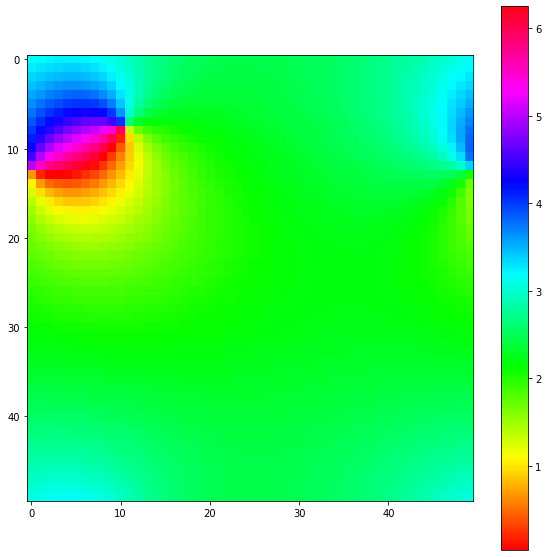

In [100]:
Lin(10, '1', lr = 0.01)
#Lin(1, 5, .1, '5_0.1_sparse-positive-lin', lr = .001)
#Lin(1, 1, .1, '1_0.1_sparse-positive-lin', lr = .01)
#Lin(1, .6, .3, '0.6_0.3_sparse-positive-lin', lr = .01)
#Lin(1, 5, 12, '5_12_sparse-positive-lin', lr = .01)

In [104]:
#global order parameter

s = 0
for i in d:
    s+= cmath.exp(complex(0, i)) 
    
abs(s)/len(d)

In [180]:
def Lin(l, s_name, lr):
    time_hist = []
    state_history_lin = []

    patience = 10
    r = list(np.zeros(patience))


    for i in range(1):
        #x = torch.eye(N)
    
        #net = nn.Linear(N, dim, bias=False)
        net = LinearSync_Sparse(N,dim)
        net.apply(init_weights)

        optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
        criterion = custom_loss_K#H
        loss_history_lin= [] 
    
        tt.tic()
        for epoch in range(200000):  
            inp = x
        
    
            optimizer.zero_grad()

            outputs = net(inp)
        
            state_history_lin += [outputs]
        
            
            loss = criterion(outputs, l)#C,  S1, S2)

    
            loss.backward(retain_graph=True)
            optimizer.step()
        
            loss_history_lin.append(loss.item())
        
        
            r.append(loss.item())
            r.pop(0)
        
       
            if (difference(r)) < 10e-8:
                print(difference(r))
                break
                
    
        
        time_hist += [tt.toc()]
        
        d = pd.DataFrame(time_hist)
        d.to_csv('./Result11_K/250x250-linear-%s-time.csv' %(s_name), header=True,index=False)

        d = pd.DataFrame(loss_history_lin)
        d.to_csv('./Result11_K/250x250-linear-%s-loss.csv' %(s_name), header=True,index=False)
        
        d = pd.DataFrame(state_history_lin[-1])
        d.to_csv('./Result11_K/250x250-linear-%s-pattern.csv' %(s_name), header=True,index=False)
        
        
        c = array([ round(double(i), 5) for i in state_history_lin[-1].detach()])
        
        plt.figure(figsize = (10,10))
        plt.imshow( ((c.reshape(250,250)%(2*pi) )), cmap = 'hsv');
        colorbar();
        plt.savefig('./Result11_K/250x250-linear-%s.svg' %(s_name));

In [181]:
def Neural(l, s_name,lr):
    time_hist = []
    state_history = []


    patience = 10
    r = list(np.zeros(patience))

    for i in range(1):
        #x = torch.eye(N)
    
        net = NeuralSync_Sparse(num_nodes=N, output_dim=dim, hidden_dim_1=10, hidden_dim_2=10, hidden_dim_3=5, adj_mtx= torch.tensor(DAD))
        #net = NeuralSync(num_nodes=N, output_dim=dim, hidden_dim_1=10, hidden_dim_2=10, hidden_dim_3=5, adj_mtx= torch.tensor(DAD))
    
    
        net.apply(init_weights)


        optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
        criterion = custom_loss_K#H
        loss_history_gcn= [] 
    
        tt.tic()
        for epoch in range(100):  
            inp = x
        
    
            optimizer.zero_grad()

            outputs = net(inp)
        
            state_history += [outputs]
        
            #print(outputs)

            loss = criterion(outputs, l) #C, S1, S2)

    
            loss.backward(retain_graph=True)
            optimizer.step()
        
            loss_history_gcn.append(loss.item())
        
            r.append(loss.item())
            r.pop(0)
            
            
            #if (difference(r)) < 10e-10:
            #    print(difference(r))
            #    break
    
        net1 = nn.Linear(N, dim, bias=False)
        net1.weight = torch.nn.Parameter(outputs.t().detach())
        optimizer1 = torch.optim.Adam(net1.parameters(), lr=lr)
    
    
        for epoch1 in range(300000):
            inp = x
    
            optimizer1.zero_grad()
            outputs1 = net1(inp)
        
            state_history += [outputs1]
        
            loss1 = criterion(outputs1, l) #C, S1, S2)

            loss1.backward(retain_graph=True)
            optimizer1.step()
        
            loss_history_gcn.append(loss1.item())
        
            r.append(loss1.item())
            r.pop(0)
        
       
            if (difference(r)) < 10e-8:
                print(difference(r))
                break
    
        
        print('Finished training neural: ', i)
    

        time_hist += [tt.toc()]
        
        d = pd.DataFrame(time_hist)
        d.to_csv('./Result11_K/250x250-neuralsync-%s-time.csv' %(s_name), header=True,index=False)

        d = pd.DataFrame(loss_history_gcn)
        d.to_csv('./Result11_K/250x250-neuralsync-%s-loss.csv' %(s_name), header=True,index=False)
        
        d = pd.DataFrame(state_history[-1])
        d.to_csv('./Result11_K/250x250-neuralsync-%s-pattern.csv' %(s_name), header=True,index=False)
        
        
        c = array([ round(double(i), 5) for i in state_history[-1].detach()])
        
        plt.figure(figsize = (10,10))
        plt.imshow( ((c.reshape(250,250)%(2*pi) )), cmap = 'hsv');
        plt.colorbar();
        
        plt.savefig('./Result11_K/250x250-neuralsync-%s.svg' %(s_name));